In [1]:

import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt


c:\Users\alsol\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\alsol\miniconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\alsol\miniconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [13]:
import pandas as pd
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize


nltk.download('punkt')
nltk.download('stopwords')


def generate_summary2(text, n):
    sentences = sent_tokenize(text)

    stop_words = set(stopwords.words('english'))

    words = [word.lower() for word in word_tokenize(text) if word.lower() not in stop_words and word.isalnum()]

    word_freq = Counter(words)

    sentence_scores = {}

    for sentence in sentences:
        sentence_words = [word.lower() for word in word_tokenize(sentence) if word.lower() not in stop_words and word.isalnum()]
        sentence_score = sum([word_freq[word] for word in sentence_words])
        if len(sentence_words) < 20:
            sentence_scores[sentence] = sentence_score

    summary_sentences = sorted(sentence_scores, key=sentence_scores.get, reverse=True)[:n]
    summary = ' '.join(summary_sentences)

    return summary


file_path = 'dataset/7.7k data.csv'
data = pd.read_csv(file_path)


data['Summary'] = data['ProductDetails'].apply(lambda x: generate_summary2(x, 1))


output_file_path = 'dataset/summarized_data2.csv'
data.to_csv(output_file_path, index=False)

print("Summarization complete. Results saved to", output_file_path)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alsol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alsol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Summarization complete. Results saved to dataset/summarized_data2.csv


Pre Processing:

Converting Profile link to ID

In [14]:
import pandas as pd
import re


df = pd.read_csv('dataset/summarized_data2.csv')


def extract_profile_id(url):
    pattern = r'amzn1\.account\.([A-Z0-9]+)'
    match = re.search(pattern, url)
    if match:
        return match.group(1)
    return None


df['ProfileID'] = df['ProfileLink'].apply(lambda x: extract_profile_id(x))


df.to_csv('dataset/train_test_profile_id.csv', index=False)  


Deleting Empty Rows

In [15]:


file_path = 'dataset/train_test_profile_id.csv' 
df = pd.read_csv(file_path)


df.dropna(subset=['OverallScore'], inplace=True)


updated_file_path = 'dataset/train_test_no_empty_rows.csv' 
df.to_csv(updated_file_path, index=False)

A. Converting to 4 Classes:


0 - 2.9 = Fake Review = (1)


3 - 5.9 = Uncertain Review = (2)


6 - 7.9 = Real Review = (3)


8 - 9 = Very Real Review = (4)

In [16]:


input_csv = 'dataset/train_test_no_empty_rows.csv'
output_csv = 'dataset/train_test_4class.csv'

df = pd.read_csv(input_csv)

def determine_label2(label): 
    if 0 <= label <= 2.9:
        return 1
    elif 3 < label <= 5.9:
        return 2
    elif 6 < label <= 7.9:
        return 3
    elif 8 < label <= 10:
        return 4
    else:
        return ''
    
df['OverallScore'] = pd.to_numeric(df['OverallScore'], errors='coerce')
df['label'] = df['OverallScore'].apply(determine_label2).dropna()    

df.to_csv(output_csv, index=False)




In [17]:


file_path = 'dataset/train_test_4class.csv'
df = pd.read_csv(file_path)


df.dropna(subset=['label'], inplace=True)


updated_file_path = 'dataset/train_test_4class_no_empty.csv' 
df.to_csv(updated_file_path, index=False)

Fix Helping Votes

In [18]:
import pandas as pd


df = pd.read_csv('dataset/train_test_4class_no_empty.csv')


print("Before conversion:")
print(df['HelpfulVote'].dtypes)


df['HelpfulVote'] = df['HelpfulVote'].str.replace(',', '').astype(float)


print("After conversion:")
print(df['HelpfulVote'].dtypes)


df.to_csv('dataset/train_test_4class_no_empty_fixed_helpful.csv', index=False)

Before conversion:
object
After conversion:
float64


B. Lower Casing

In [19]:


input_csv = 'dataset/train_test_4class_no_empty_fixed_helpful_lower_punch_stopwords_emotion_outliers_eng.csv'
output_csv = 'dataset/train_test_4class_no_empty_fixed_helpful_lower_punch_stopwords_emotion_outliers_eng_fixed.csv'

data_lower = pd.read_csv(input_csv)

columns_to_lower = ['ReviewDetails', 'ProductTitle', 'ProductDetails', 'ReviewerName', 'ReviewTitle', 'ProfileID']

data_lower[columns_to_lower] = data_lower[columns_to_lower].apply(lambda x: x.str.lower())

data_lower.to_csv(output_csv, index=False)

C. Remove All Punchuation

In [20]:
import string

In [21]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [22]:

input_csv = 'dataset/train_test_4class_no_empty_fixed_helpful_lower.csv'
output_csv = 'dataset/train_test_4class_no_empty_fixed_helpful_lower_punch.csv'

data_punctuation = pd.read_csv(input_csv)


translator = str.maketrans('', '', string.punctuation)


def remove_punctuation(text):
    if isinstance(text, str) and any(char.isalnum() or char.isspace() for char in text):
        return text.translate(translator)
    else:
        return ''

columns_to_punctuation = ['ReviewDetails', 'ProductTitle', 'ProductDetails', 'ReviewerName', 'ReviewTitle']


data_punctuation[columns_to_punctuation] = data_punctuation[columns_to_punctuation].applymap(remove_punctuation)


data_punctuation.to_csv(output_csv, index=False)


D. Remove All Stopwords (!! Note: Removing Stopwords can have a negative impact on Bert !!)

In [23]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [23]:
input_csv = 'dataset/train_test_4class_no_empty_fixed_helpful_lower_punch.csv'
output_csv = 'dataset/train_test_4class_no_empty_fixed_helpful_lower_punch_stopwords.csv'

data_stopwords = pd.read_csv(input_csv)

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

columns_for_stopwords = ['ReviewDetails', 'ProductTitle', 'ProductDetails', 'ReviewerName', 'ReviewTitle']

data_stopwords[columns_for_stopwords] = data_stopwords[columns_for_stopwords].applymap(lambda text: remove_stopwords(text))

data_stopwords.to_csv(output_csv, index=False)

Outlier Removal

In [29]:
input_csv = 'dataset/train_test_4class_no_empty_fixed_helpful_lower_punch_stopwords_emotion.csv'
df = pd.read_csv(input_csv)

C:\Users\alsol\AppData\Local\Temp\ipykernel_19600\58348243.py:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['ReviewLength'])
C:\Users\alsol\AppData\Local\Temp\ipykernel_19600\58348243.py:30: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df['ReviewLength'])


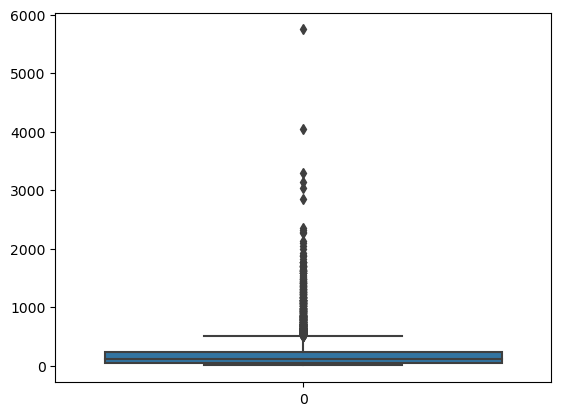

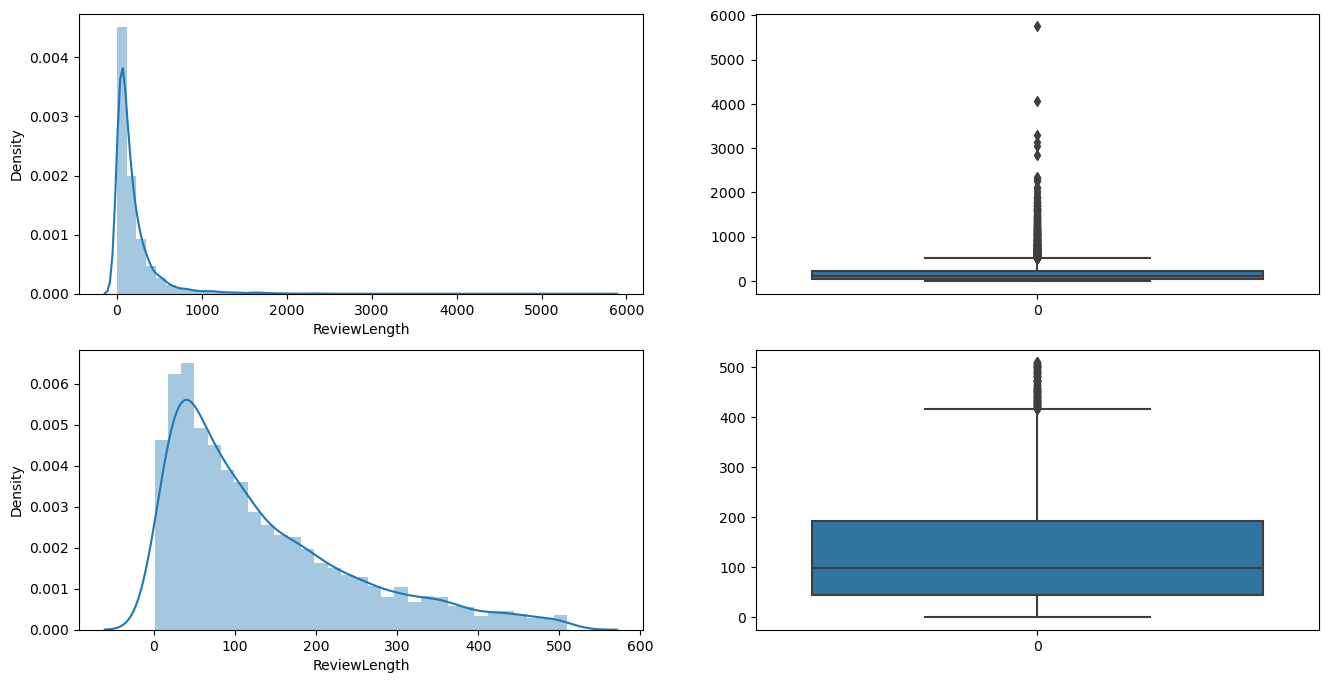

C:\Users\alsol\AppData\Local\Temp\ipykernel_19600\58348243.py:50: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['ReviewLength'])
C:\Users\alsol\AppData\Local\Temp\ipykernel_19600\58348243.py:54: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df_cap['ReviewLength'])


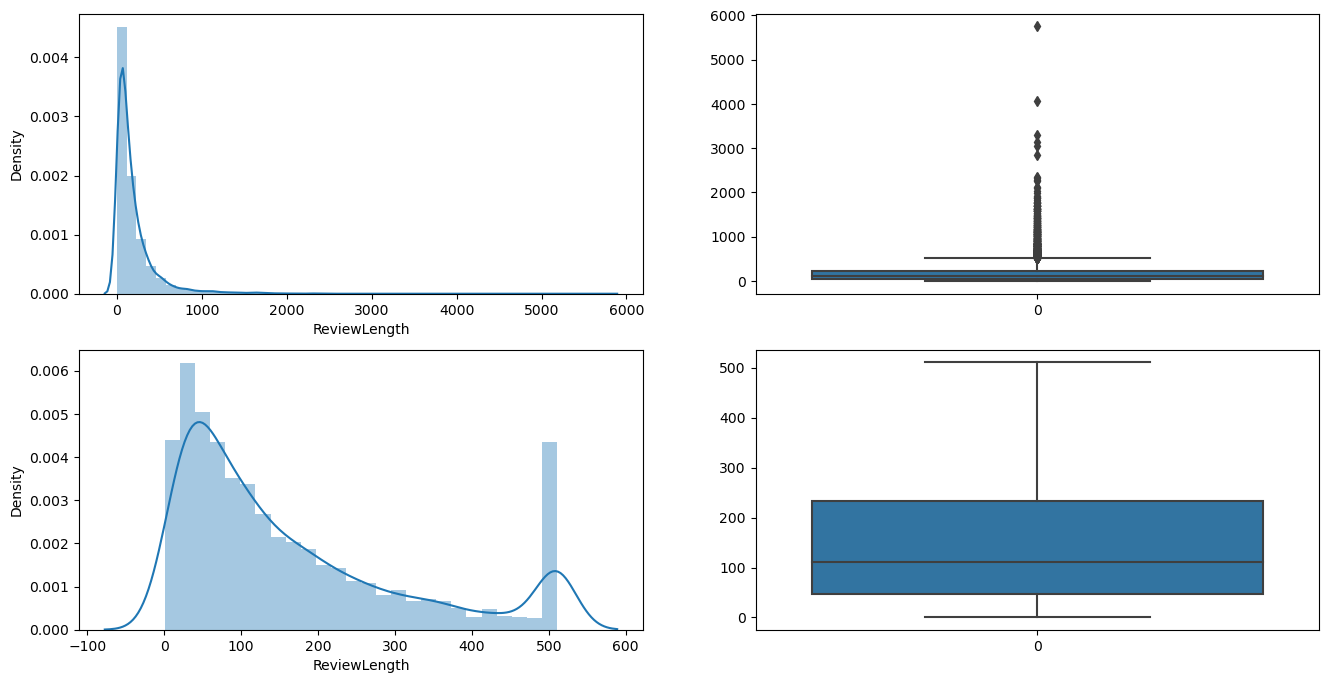

In [30]:
# Calculate the lengths of the reviews
df['ReviewLength'] = df['ReviewDetails'].str.len()

# Step-4: Form a box-plot for the skewed feature
sns.boxplot(df['ReviewLength'])

# Step-5: Finding the IQR
percentile25 = df['ReviewLength'].quantile(0.25)
percentile75 = df['ReviewLength'].quantile(0.75)
iqr = percentile75 - percentile25

# Step-6: Finding the upper and lower limits
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

# Step-7: Finding outliers
outliers_upper = df[df['ReviewLength'] > upper_limit]
outliers_lower = df[df['ReviewLength'] < lower_limit]

# Step-8: Trimming outliers
new_df = df[(df['ReviewLength'] < upper_limit) & (df['ReviewLength'] > lower_limit)]

# Step-9: Compare the plots after trimming
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(df['ReviewLength'])
plt.subplot(2,2,2)
sns.boxplot(df['ReviewLength'])
plt.subplot(2,2,3)
sns.distplot(new_df['ReviewLength'])
plt.subplot(2,2,4)
sns.boxplot(new_df['ReviewLength'])
plt.show()

# Step-10: Capping
new_df_cap = df.copy()
new_df_cap['ReviewLength'] = np.where(
    new_df_cap['ReviewLength'] > upper_limit,
    upper_limit,
    np.where(
        new_df_cap['ReviewLength'] < lower_limit,
        lower_limit,
        new_df_cap['ReviewLength']
    )
)

# Step-11: Compare the plots after capping
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(df['ReviewLength'])
plt.subplot(2,2,2)
sns.boxplot(df['ReviewLength'])
plt.subplot(2,2,3)
sns.distplot(new_df_cap['ReviewLength'])
plt.subplot(2,2,4)
sns.boxplot(new_df_cap['ReviewLength'])
plt.show()

new_df.to_csv('dataset/train_test_4class_no_empty_fixed_helpful_lower_punch_stopwords_emotion_outliers.csv', index=False)

In [34]:
input_csv = 'data_without_outliers.csv'
df = pd.read_csv(input_csv)

longest_review = df['ReviewDetails'][df['ReviewLength'].idxmax()]
print(longest_review)

got due canadian fire pollution great northeast summer hubby hvac “master” 50 years says one works well large area indicator light tell us inside air needs filtering since keep track air mostly leave auto thing also picks oven arrived original manufacturers box great shape notice noise low fan runs draw back it’s wheels want move pick 22x19x8 inches it’s rather bulky move hepa replacement filters also rather expensive we’re talking breathing acceptable air knock offs bought another family members


E. Removing anything that is not in English and 0-9

In [31]:
import pandas as pd
import re


input_csv = 'dataset/train_test_4class_no_empty_fixed_helpful_lower_punch_stopwords_emotion_outliers.csv'
output_csv = 'dataset/train_test_4class_no_empty_fixed_helpful_lower_punch_stopwords_emotion_outliers_eng.csv'
data = pd.read_csv(input_csv)


columns_to_process = ['ReviewDetails', 'ProductTitle', 'ProductDetails', 'ReviewerName', 'ReviewTitle']


def remove_non_english_and_non_numeric(text):
    # Remove non-English and non-numeric characters
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    return cleaned_text


for col in columns_to_process:
    data[col] = data[col].apply(remove_non_english_and_non_numeric)


data.to_csv(output_csv, index=False)


F. Emotion Conversion

In [26]:
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [27]:
import pandas as pd
import re


input_csv = 'dataset/train_test_4class_no_empty_fixed_helpful_lower_punch_stopwords.csv'
output_csv = 'dataset/train_test_4class_no_empty_fixed_helpful_lower_punch_stopwords_emotion.csv'
data = pd.read_csv(input_csv)


columns_to_process = ['ReviewDetails', 'ProductTitle', 'ProductDetails', 'ReviewerName', 'ReviewTitle']


def convert_emoticons(text):

    if isinstance(text, str):
        for emot in EMOTICONS:
            text = re.sub(u'(' + emot + ')', "_".join(EMOTICONS[emot].replace(",", "").split()), text)
    return text

for col in columns_to_process:
    data[col] = data[col].apply(convert_emoticons)

data.to_csv(output_csv, index=False)
